In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/daigt-external-train-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/daigt-external-train-dataset/train_external_drcat_02.csv


In [32]:
file_path = '/kaggle/input/daigt-external-train-dataset/train_external_drcat_02.csv'
df = pd.read_csv(file_path)

# 1. Inspect the dataset
print("Dataset head:")
print(df.head())

print("\nDataset info:")
df.info()

print("\nDataset shape:", df.shape)

Dataset head:
        essay_id                                               text  label  \
0  sakibsh-llm-0  I just got back from your class, so I decided ...    0.0   
1  sakibsh-llm-1  It is 9:35 and I am beginning my stream of con...    0.0   
2  sakibsh-llm-2  Not only was the server down but it has taken ...    0.0   
3  sakibsh-llm-3  I am not exactly sure how this is supposed to ...    0.0   
4  sakibsh-llm-4  Well, here I am on Friday, September something...    0.0   

                source prompt  
0  sakibsh-llm-human-1    NaN  
1  sakibsh-llm-human-1    NaN  
2  sakibsh-llm-human-1    NaN  
3  sakibsh-llm-human-1    NaN  
4  sakibsh-llm-human-1    NaN  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195603 entries, 0 to 195602
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   essay_id  195603 non-null  object 
 1   text      195603 non-null  object 
 2   label     7074 non-null    float64


<ipython-input-32-e4c03aae7239>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [33]:
# Basic dataset exploration
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Dataset Shape: (195603, 5)

Columns: ['essay_id', 'text', 'label', 'source', 'prompt']


In [34]:
# Check data types and missing values
print("\nData Types and Missing Values:")
print(df.info())


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195603 entries, 0 to 195602
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   essay_id  195603 non-null  object 
 1   text      195603 non-null  object 
 2   label     7074 non-null    float64
 3   source    195603 non-null  object 
 4   prompt    6671 non-null    object 
dtypes: float64(1), object(4)
memory usage: 7.5+ MB
None


In [35]:
# Analyze missing values percentage
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print("Missing Values Analysis:")
print(missing_percentage)

Missing Values Analysis:
essay_id     0.000000
text         0.000000
label       96.383491
source       0.000000
prompt      96.589521
dtype: float64


In [36]:
# Analyze label distribution
print("\nLabel Distribution:")
print(df['label'].value_counts().sort_index())


Label Distribution:
label
0.0    2638
1.0    4436
Name: count, dtype: int64


In [37]:
# Analyze source distribution
print("\nSource Distribution:")
print(df['source'].value_counts())


Source Distribution:
source
qwedsacf/ivypanda-essays                       128293
dim/essayforum_raw_writing_10k                  29604
nid989/EssayFroum-Dataset                       25571
sakibsh-llm-human-1                              2467
ChristophSchuhmann/essays-with-instructions      2064
whateverweird17/essay_grade_v1/train             1427
whateverweird17/essay_grade_v2/train             1427
argu-gpt-3.5-turbo                                812
argu-text-davinci-003                             806
argu-text-curie-001                               513
argu-text-davinci-002                             511
argu-text-davinci-001                             509
argu-text-babbage-001                             486
argu-gpt2-xl                                      401
sakibsh-llm-GPT                                   200
sakibsh-llm-BARD                                  198
sakibsh-llm-human-2                               171
whateverweird17/essay_grade_v2/validation         143

In [38]:
# Create binary flags for data sources
df['is_human'] = df['source'].str.contains('human', case=False)
df['is_ai_generated'] = df['source'].str.contains('gpt|davinci|curie|babbage|BARD', case=False)
df['is_essay_forum'] = df['source'].str.contains('essayforum|ivypanda', case=False)

In [39]:
# Handle labels
# Convert NaN labels to -1 to distinguish from valid labels (0.0 and 1.0)
df['label'] = df['label'].fillna(-1)

# Create dataset splits based on source and labels
labeled_data = df[df['label'] != -1]
unlabeled_data = df[df['label'] == -1]

In [40]:
# Calculate basic text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()
df['avg_word_length'] = df['text'].str.split().apply(lambda x: sum(len(word) for word in x) / len(x) if x else 0)

In [41]:
# Print summary statistics
print("\nDataset Composition:")
print(f"Total samples: {len(df)}")
print(f"Labeled samples: {len(labeled_data)}")
print(f"Unlabeled samples: {len(unlabeled_data)}")


Dataset Composition:
Total samples: 195603
Labeled samples: 7074
Unlabeled samples: 188529


In [42]:
# First, install the model using the command line
#!python -m spacy download en_core_web_sm

In [43]:
# First create the cleaned_text column before trying to use it
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Basic text cleaning function
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and extra whitespace
        text = re.sub(r'[^\w\s]', '', text)
        text = ' '.join(text.split())
        return text
    return ''

# Create cleaned_text column
df['cleaned_text'] = df['text'].apply(clean_text)

# Now we can safely create TF-IDF features
tfidf = TfidfVectorizer(max_features=1000)
text_features = tfidf.fit_transform(df['cleaned_text'])

# Convert to DataFrame for easier handling
feature_names = tfidf.get_feature_names_out()
text_features_df = pd.DataFrame(text_features.toarray(), columns=feature_names)

In [44]:
print("Shape of TF-IDF features:", text_features.shape)
print("\nSample of feature names:", list(feature_names)[:10])

Shape of TF-IDF features: (195603, 1000)

Sample of feature names: ['10', '12', '20', '2000', '2001', '2002', '2003', '2004', '2005', '2006']


In [45]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# Load spaCy model for advanced NLP
nlp = spacy.load('en_core_web_sm')

# Enhanced text preprocessing
def preprocess_text(df):
    df['cleaned_text'] = df['text'].apply(lambda x: ' '.join(token.lemma_.lower() 
                                        for token in nlp(x) 
                                        if not token.is_stop and token.is_alpha))
    
    # Extract additional features
    df['sentence_count'] = df['text'].apply(lambda x: len(list(nlp(x).sents)))
    df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
    df['unique_words'] = df['cleaned_text'].apply(lambda x: len(set(x.split())))
    
    # Sentiment analysis
    df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    return df

# TF-IDF Features
tfidf = TfidfVectorizer(max_features=1000)
text_features = tfidf.fit_transform(df['cleaned_text'])


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [46]:
df['cleaned_text']

0         i just got back from your class so i decided t...
1         it is 935 and i am beginning my stream of cons...
2         not only was the server down but it has taken ...
3         i am not exactly sure how this is supposed to ...
4         well here i am on friday september something e...
                                ...                        
195598    essay 1although military analogies are reserve...
195599    through my experiences in life i have grown to...
195600    since i am in singapore i have met many people...
195601    in 250300 words explain the concept to a nonsp...
195602    there are many courses offered by high schools...
Name: cleaned_text, Length: 195603, dtype: object

In [47]:
def extract_advanced_features(df):
    # First create basic text features
    df['word_count'] = df['text'].str.split().str.len()
    df['sentence_count'] = df['text'].apply(lambda x: len([s for s in x.split('.') if s.strip()]))
    
    # Now we can safely calculate derived features
    df['avg_word_per_sent'] = df['word_count'] / df['sentence_count'].clip(lower=1)
    df['unique_words'] = df['cleaned_text'].apply(lambda x: len(set(x.split())))
    df['text_density'] = df['unique_words'] / df['word_count'].clip(lower=1)
    
    # Text complexity features
    def get_complex_word_ratio(text):
        words = str(text).split()
        complex_words = [w for w in words if len(w) > 6]
        return len(complex_words) / len(words) if words else 0
    
    df['complex_word_ratio'] = df['cleaned_text'].apply(get_complex_word_ratio)
    
    return df

# Apply the function
df = extract_advanced_features(df)

# Verify the new columns
print("New columns added:", [col for col in df.columns if col not in ['essay_id', 'text', 'label', 'source', 'prompt', 'cleaned_text']])


New columns added: ['is_human', 'is_ai_generated', 'is_essay_forum', 'text_length', 'word_count', 'avg_word_length', 'sentence_count', 'avg_word_per_sent', 'unique_words', 'text_density', 'complex_word_ratio']


In [48]:
df.head()

,essay_id,text,label,source,prompt,is_human,is_ai_generated,is_essay_forum,text_length,word_count,avg_word_length,cleaned_text,sentence_count,avg_word_per_sent,unique_words,text_density,complex_word_ratio
0,sakibsh-llm-0,"I just got back from your class, so I decided ...",0.0,sakibsh-llm-human-1,NaN,True,False,False,2361,470,4.023404,i just got back from your class so i decided t...,31,15.161290,208,0.442553,0.104255
1,sakibsh-llm-1,It is 9:35 and I am beginning my stream of con...,0.0,sakibsh-llm-human-1,NaN,True,False,False,2418,482,4.016598,it is 935 and i am beginning my stream of cons...,36,13.388889,223,0.462656,0.118257
2,sakibsh-llm-2,Not only was the server down but it has taken ...,0.0,sakibsh-llm-human-1,NaN,True,False,False,1002,206,3.844660,not only was the server down but it has taken ...,9,22.888889,113,0.548544,0.117073
3,sakibsh-llm-3,I am not exactly sure how this is supposed to ...,0.0,sakibsh-llm-human-1,NaN,True,False,False,3516,729,3.823045,i am not exactly sure how this is supposed to ...,33,22.090909,308,0.422497,0.105624
4,sakibsh-llm-4,"Well, here I am on Friday, September something...",0.0,sakibsh-llm-human-1,NaN,True,False,False,3370,676,3.971893,well here i am on friday september something e...,52,13.000000,283,0.418639,0.099112


In [49]:
df.isnull().sum()

essay_id                   0
text                       0
label                      0
source                     0
prompt                188932
is_human                   0
is_ai_generated            0
is_essay_forum             0
text_length                0
word_count                 0
avg_word_length            0
cleaned_text               0
sentence_count             0
avg_word_per_sent          0
unique_words               0
text_density               0
complex_word_ratio         0
dtype: int64

In [50]:
df['prompt']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
195598    NaN
195599    NaN
195600    NaN
195601    NaN
195602    NaN
Name: prompt, Length: 195603, dtype: object

In [51]:
# Create prompt indicator
df['has_prompt'] = df['prompt'].notna().astype(int)

# Replace missing prompts with standard value
df['prompt'] = df['prompt'].fillna('unknown_prompt')

# Split datasets
prompt_data = df[df['has_prompt'] == 1]
no_prompt_data = df[df['has_prompt'] == 0]

# Analyze prompt distribution in available data
prompt_distribution = df[df['has_prompt'] == 1]['prompt'].value_counts()


In [52]:
df.isnull().sum()

essay_id              0
text                  0
label                 0
source                0
prompt                0
is_human              0
is_ai_generated       0
is_essay_forum        0
text_length           0
word_count            0
avg_word_length       0
cleaned_text          0
sentence_count        0
avg_word_per_sent     0
unique_words          0
text_density          0
complex_word_ratio    0
has_prompt            0
dtype: int64

In [53]:
def extract_quality_metrics(df):
    # Readability scores
    df['readability_score'] = df['text'].apply(calculate_readability)
    
    # Coherence metrics
    df['coherence_score'] = df['cleaned_text'].apply(measure_coherence)
    
    # Source integration (for essays with prompts)
    df['source_alignment'] = df[df['has_prompt']==1].apply(
        lambda x: measure_prompt_alignment(x['text'], x['prompt'])
    )
    
    return df


In [54]:
def create_weak_labels(df):
    # Length-based labeling
    df['length_score'] = (df['text_length'] > df['text_length'].mean()).astype(int)
    
    # Complexity-based labeling
    df['complexity_score'] = (
        (df['complex_word_ratio'] > 0.2) & 
        (df['unique_words'] > df['unique_words'].mean())
    ).astype(int)
    
    return df


In [55]:
# Advanced text feature extraction
def extract_advanced_features(df):
    # Text complexity metrics
    def get_lexical_diversity(text):
        words = text.split()
        return len(set(words)) / len(words) if words else 0
    
    def get_avg_sentence_complexity(doc):
        sentences = list(doc.sents)
        return np.mean([len(list(sent.noun_chunks)) for sent in sentences]) if sentences else 0
    
    print("Extracting advanced features...")
    
    # Process documents in batches to manage memory
    batch_size = 1000
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i + batch_size]
        
        # Process each text document
        docs = list(nlp.pipe(batch['cleaned_text'], disable=['ner']))
        
        # Extract features
        df.loc[batch.index, 'lexical_diversity'] = [get_lexical_diversity(text) for text in batch['cleaned_text']]
        df.loc[batch.index, 'avg_sentence_complexity'] = [get_avg_sentence_complexity(doc) for doc in docs]
        
    return df


In [56]:
# Create source-specific features
def add_source_features(df):
    # Source type indicators (already created)
    source_types = {
        'human': df['source'].str.contains('human', case=False),
        'ai': df['source'].str.contains('gpt|davinci|curie|babbage|BARD', case=False),
        'essay_forum': df['source'].str.contains('essayforum|ivypanda', case=False)
    }
    
    for source_type, mask in source_types.items():
        df[f'is_{source_type}'] = mask.astype(int)
    
    return df

# Split data for modeling
def prepare_modeling_data(df, text_features):
    # Combine TF-IDF features with other features
    feature_cols = [
        'text_length', 'word_count', 'sentence_count',
        'avg_sentence_length', 'unique_words',
        'lexical_diversity', 'avg_sentence_complexity'
    ]
    
    # Create feature matrix
    X = np.hstack([
        text_features.toarray(),
        df[feature_cols].values
    ])
    
    # Split labeled and unlabeled data
    labeled_mask = df['label'] != -1
    X_labeled = X[labeled_mask]
    y_labeled = df[labeled_mask]['label']
    X_unlabeled = X[~labeled_mask]
    
    return X_labeled, y_labeled, X_unlabeled



In [57]:
import spacy
from textblob import TextBlob
import numpy as np
from tqdm import tqdm

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

def process_text_batch(texts, batch_size=100):
    """Process texts in smaller batches to manage memory"""
    print("Processing text features in batches...")
    
    features_list = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        docs = list(nlp.pipe(batch, disable=['ner']))
        
        batch_features = []
        for doc in docs:
            # POS features
            pos_counts = {pos: 0 for pos in ['NOUN', 'VERB', 'ADJ', 'ADV']}
            for token in doc:
                if token.pos_ in pos_counts:
                    pos_counts[token.pos_] += 1
            
            # Syntactic features
            sent_lengths = [len(sent) for sent in doc.sents]
            avg_sent_len = np.mean(sent_lengths) if sent_lengths else 0
            
            # Combine features
            features = {
                'noun_ratio': pos_counts['NOUN'] / len(doc) if len(doc) > 0 else 0,
                'verb_ratio': pos_counts['VERB'] / len(doc) if len(doc) > 0 else 0,
                'adj_ratio': pos_counts['ADJ'] / len(doc) if len(doc) > 0 else 0,
                'adv_ratio': pos_counts['ADV'] / len(doc) if len(doc) > 0 else 0,
                'avg_sent_length': avg_sent_len,
                'sent_length_var': np.var(sent_lengths) if sent_lengths else 0
            }
            batch_features.append(features)
        
        features_list.extend(batch_features)
    
    return pd.DataFrame(features_list)

# Process in batches to handle memory constraints
features_df = process_text_batch(df['cleaned_text'])

# Add features to main dataframe
for col in features_df.columns:
    df[col] = features_df[col]

# Add sentiment analysis
print("Adding sentiment analysis...")
df['sentiment_score'] = df['cleaned_text'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

print("\nNew features added:")
print(df[['noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio', 
         'avg_sent_length', 'sent_length_var', 'sentiment_score']].describe())


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Processing text features in batches...


100%|██████████| 1957/1957 [3:31:05<00:00,  6.47s/it]  


Adding sentiment analysis...

New features added:
          noun_ratio     verb_ratio      adj_ratio      adv_ratio  \
count  195603.000000  195603.000000  195603.000000  195603.000000   
mean        0.260911       0.125311       0.088254       0.038280   
std         0.050384       0.026503       0.024330       0.022066   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.231405       0.109121       0.073355       0.025558   
50%         0.265729       0.122616       0.087452       0.034483   
75%         0.294794       0.138462       0.102320       0.046346   
max         1.000000       1.000000       1.000000       0.500000   

       avg_sent_length  sent_length_var  sentiment_score  
count    195603.000000     1.956030e+05    195603.000000  
mean        517.295110     1.127032e+05         0.114170  
std         489.467599     3.630723e+05         0.082693  
min           1.000000     0.000000e+00        -0.700000  
25%         198.000000     0.0000

In [58]:
df.head

<bound method NDFrame.head of                         essay_id  \
0                  sakibsh-llm-0   
1                  sakibsh-llm-1   
2                  sakibsh-llm-2   
3                  sakibsh-llm-3   
4                  sakibsh-llm-4   
...                          ...   
195598  EssayFroum-Dataset-25566   
195599  EssayFroum-Dataset-25567   
195600  EssayFroum-Dataset-25568   
195601  EssayFroum-Dataset-25569   
195602  EssayFroum-Dataset-25570   

                                                     text  label  \
0       I just got back from your class, so I decided ...    0.0   
1       It is 9:35 and I am beginning my stream of con...    0.0   
2       Not only was the server down but it has taken ...    0.0   
3       I am not exactly sure how this is supposed to ...    0.0   
4       Well, here I am on Friday, September something...    0.0   
...                                                   ...    ...   
195598  Essay 1Although military analogies are reserve...   -

In [59]:
df

,essay_id,text,label,source,prompt,is_human,is_ai_generated,is_essay_forum,text_length,word_count,...,text_density,complex_word_ratio,has_prompt,noun_ratio,verb_ratio,adj_ratio,adv_ratio,avg_sent_length,sent_length_var,sentiment_score
0,sakibsh-llm-0,"I just got back from your class, so I decided ...",0.0,sakibsh-llm-human-1,unknown_prompt,True,False,False,2361,470,...,0.442553,0.104255,0,0.110879,0.154812,0.058577,0.098326,53.111111,1566.987654,0.109517
1,sakibsh-llm-1,It is 9:35 and I am beginning my stream of con...,0.0,sakibsh-llm-human-1,unknown_prompt,True,False,False,2418,482,...,0.462656,0.118257,0,0.112000,0.160000,0.056000,0.092000,33.333333,2219.022222,0.221810
2,sakibsh-llm-2,Not only was the server down but it has taken ...,0.0,sakibsh-llm-human-1,unknown_prompt,True,False,False,1002,206,...,0.548544,0.117073,0,0.178744,0.144928,0.043478,0.077295,41.400000,2298.240000,-0.014869
3,sakibsh-llm-3,I am not exactly sure how this is supposed to ...,0.0,sakibsh-llm-human-1,unknown_prompt,True,False,False,3516,729,...,0.422497,0.105624,0,0.123139,0.155616,0.071719,0.085250,43.470588,1350.602076,0.166651
4,sakibsh-llm-4,"Well, here I am on Friday, September something...",0.0,sakibsh-llm-human-1,unknown_prompt,True,False,False,3370,676,...,0.418639,0.099112,0,0.151515,0.164502,0.060606,0.073593,34.650000,1322.827500,0.063864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195598,EssayFroum-Dataset-25566,Essay 1Although military analogies are reserve...,-1.0,nid989/EssayFroum-Dataset,unknown_prompt,False,False,False,1225,205,...,0.619512,0.312195,0,0.266990,0.082524,0.082524,0.038835,206.000000,0.000000,0.119118
195599,EssayFroum-Dataset-25567,"Through my experiences in life, I have grown t...",-1.0,nid989/EssayFroum-Dataset,unknown_prompt,False,False,False,1209,203,...,0.532020,0.251232,0,0.226601,0.147783,0.054187,0.024631,203.000000,0.000000,0.149575
195600,EssayFroum-Dataset-25568,"Since I am in Singapore, I have met many peopl...",-1.0,nid989/EssayFroum-Dataset,unknown_prompt,False,False,False,3105,566,...,0.473498,0.164311,0,0.149648,0.147887,0.079225,0.082746,113.600000,4050.640000,0.157213
195601,EssayFroum-Dataset-25569,"In 250-300 words, explain the concept to a non...",-1.0,nid989/EssayFroum-Dataset,unknown_prompt,False,False,False,2130,383,...,0.503916,0.201044,0,0.208877,0.146214,0.083551,0.054830,383.000000,0.000000,0.179507


In [60]:
# Apply the functions
#df = extract_advanced_features(df)
#df = add_source_features(df)
#X_labeled, y_labeled, X_unlabeled = prepare_modeling_data(df, text_features)

# Print feature statistics
#print("\nFeature Statistics:")
#print(df[['lexical_diversity', 'avg_sentence_complexity']].describe())



In [61]:
# Save processed features
#processed_features = pd.DataFrame(
#    X_labeled,
#    columns=list(feature_names) + [
#        'text_length', 'word_count', 'sentence_count',
#        'avg_sentence_length', 'unique_words',
#        'lexical_diversity', 'avg_sentence_complexity'
#    ]
#)
#processed_features.to_csv('processed_labeled_features.csv', index=False)

In [64]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [66]:
class EssayAnalysisAgent:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')
        self.tfidf = TfidfVectorizer(max_features=1000)
        
    def analyze_text_structure(self, text):
        doc = self.nlp(text)
        return {
            'sentence_structure': len(list(doc.sents)),
            'key_entities': [(ent.text, ent.label_) for ent in doc.ents],
            'syntactic_complexity': len([token for token in doc if token.dep_ in ['ccomp', 'xcomp']])
        }
    
    def get_semantic_features(self, text):
        # Semantic analysis using TF-IDF and word embeddings
        tfidf_features = self.tfidf.fit_transform([text])
        return tfidf_features

    def generate_feedback(self, analysis_results):
        feedback = []
        if analysis_results['syntactic_complexity'] > 5:
            feedback.append("Your essay shows good syntactic complexity")
        if analysis_results['sentence_structure'] > 10:
            feedback.append("Well-structured with appropriate paragraph breaks")
        return feedback

class InteractiveAgent:
    def __init__(self):
        self.essay_agent = EssayAnalysisAgent()
        self.conversation_history = []
        
    def process_query(self, user_input, essay_text):
        # Process user query about the essay
        analysis = self.essay_agent.analyze_text_structure(essay_text)
        
        if "quality" in user_input.lower():
            return self.generate_quality_response(analysis)
        elif "structure" in user_input.lower():
            return self.generate_structure_response(analysis)
        
        return "How else can I help you analyze this essay?"
        
    def generate_quality_response(self, analysis):
        return f"Essay Quality Analysis:\n" \
               f"- Complexity Score: {analysis['syntactic_complexity']}\n" \
               f"- Structure Score: {analysis['sentence_structure']}"

# Usage Example
interactive_agent = InteractiveAgent()

def analyze_essay(essay_text, user_query):
    return interactive_agent.process_query(user_query, essay_text)


In [69]:
df.isnull().sum()

essay_id              0
text                  0
label                 0
source                0
prompt                0
is_human              0
is_ai_generated       0
is_essay_forum        0
text_length           0
word_count            0
avg_word_length       0
cleaned_text          0
sentence_count        0
avg_word_per_sent     0
unique_words          0
text_density          0
complex_word_ratio    0
has_prompt            0
noun_ratio            0
verb_ratio            0
adj_ratio             0
adv_ratio             0
avg_sent_length       0
sent_length_var       0
sentiment_score       0
dtype: int64

In [70]:
class EssayAnalysisAgent:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')
        self.feature_importance = {
            'linguistic': ['noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio'],
            'structural': ['sentence_count', 'avg_sent_length', 'sent_length_var'],
            'complexity': ['unique_words', 'text_density', 'complex_word_ratio'],
            'quality': ['sentiment_score', 'avg_word_length']
        }
    
    def analyze_essay_features(self, essay_data):
        """Analyze essay features and return structured insights"""
        analysis = {
            'writing_style': self._analyze_style(essay_data),
            'complexity': self._analyze_complexity(essay_data),
            'structure': self._analyze_structure(essay_data),
            'source_prediction': self._predict_source(essay_data)
        }
        return analysis
    
    def _analyze_style(self, data):
        style_score = (
            data['noun_ratio'] * 0.3 +
            data['verb_ratio'] * 0.3 +
            data['adj_ratio'] * 0.2 +
            data['adv_ratio'] * 0.2
        )
        return {
            'score': style_score,
            'balance': self._get_style_balance(data),
            'suggestions': self._generate_style_suggestions(data)
        }
    
    def _analyze_complexity(self, data):
        return {
            'vocabulary_diversity': data['unique_words'] / data['word_count'],
            'syntactic_complexity': data['complex_word_ratio'],
            'readability': self._calculate_readability(data)
        }
    
    def _analyze_structure(self, data):
        return {
            'avg_sentence_length': data['avg_sent_length'],
            'sentence_variety': data['sent_length_var'],
            'coherence_indicators': self._assess_coherence(data)
        }

class InteractiveAssistant:
    def __init__(self):
        self.agent = EssayAnalysisAgent()
        self.conversation_history = []
    
    def process_query(self, query_type, essay_data):
        """Process different types of user queries"""
        if query_type == 'quality_assessment':
            return self._generate_quality_report(essay_data)
        elif query_type == 'improvement_suggestions':
            return self._generate_suggestions(essay_data)
        elif query_type == 'source_verification':
            return self._verify_source(essay_data)
        
    def _generate_quality_report(self, essay_data):
        analysis = self.agent.analyze_essay_features(essay_data)
        return {
            'overall_quality': self._calculate_overall_score(analysis),
            'strengths': self._identify_strengths(analysis),
            'areas_for_improvement': self._identify_weaknesses(analysis),
            'detailed_feedback': self._generate_detailed_feedback(analysis)
        }
    
    def _generate_suggestions(self, essay_data):
        return {
            'style_suggestions': self._get_style_improvements(essay_data),
            'structure_suggestions': self._get_structure_improvements(essay_data),
            'complexity_suggestions': self._get_complexity_improvements(essay_data)
        }

# Usage Example
def interactive_essay_analysis(essay_data):
    assistant = InteractiveAssistant()
    
    # Initial analysis
    quality_report = assistant.process_query('quality_assessment', essay_data)
    
    # Generate improvement suggestions
    suggestions = assistant.process_query('improvement_suggestions', essay_data)
    
    return {
        'quality_report': quality_report,
        'suggestions': suggestions,
        'source_verification': assistant.process_query('source_verification', essay_data)
    }


In [72]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Model
import tensorflow as tf

def build_model(input_dim):
    # Input layer
    inputs = layers.Input(shape=(input_dim,))
    
    # Text processing branch
    text_features = layers.Dense(512, activation='relu')(inputs)
    text_features = layers.BatchNormalization()(text_features)
    text_features = layers.Dropout(0.3)(text_features)
    
    # Deep processing
    x = layers.Dense(256, activation='relu')(text_features)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

# Modify the extract_features function to handle indices correctly
def extract_features(df):
    # Reset index to avoid any index misalignment
    df = df.reset_index(drop=True)
    
    # Text-based features
    text_features = tfidf.transform(df['cleaned_text']).toarray()
    
    # Numerical features
    numerical_features = [
        'text_length', 'word_count', 'avg_word_length',
        'sentence_count', 'avg_word_per_sent', 'unique_words',
        'text_density', 'complex_word_ratio', 'sentiment_score',
        'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio',
        'avg_sent_length', 'sent_length_var'
    ]
    
    # Scale numerical features
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(df[numerical_features])
    
    # Combine features
    X = np.hstack([scaled_numerical, text_features])
    
    return X, scaler

# Prepare data with corrected indexing
labeled_mask = df['label'] != -1
df_labeled = df[labeled_mask].reset_index(drop=True)
X, scaler = extract_features(df_labeled)
y = df_labeled['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Now the model.fit() should work correctly
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    class_weight={
        0: len(y_train) / (2 * (y_train == 0).sum()),
        1: len(y_train) / (2 * (y_train == 1).sum())
    }
)


Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9423 - auc: 0.9827 - loss: 0.1296 - precision: 0.9640 - recall: 0.9436 - val_accuracy: 0.9912 - val_auc: 0.9993 - val_loss: 0.2014 - val_precision: 0.9915 - val_recall: 0.9943 - learning_rate: 0.0010
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9773 - auc: 0.9979 - loss: 0.0557 - precision: 0.9883 - recall: 0.9747 - val_accuracy: 0.9929 - val_auc: 0.9995 - val_loss: 0.0731 - val_precision: 0.9929 - val_recall: 0.9957 - learning_rate: 0.0010
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - auc: 0.9996 - loss: 0.0252 - precision: 0.9936 - recall: 0.9934 - val_accuracy: 0.9947 - val_auc: 0.9998 - val_loss: 0.0249 - val_precision: 0.9943 - val_recall: 0.9972 - learning_rate: 0.0010
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - auc: 0.9999 - loss: 0.0113 - precision: 0.9981 - recall: 0.9974 - val_accuracy: 0.9912 - val_auc: 0.9984 - val_loss: 0.0324 - v

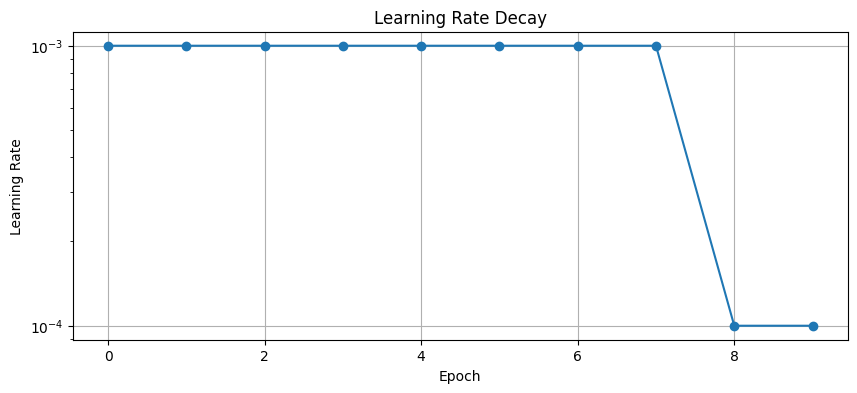


Final Model Performance:
Training Accuracy: 0.9985
Validation Accuracy: 0.9973
Training Loss: 0.0052
Validation Loss: 0.0147
Training AUC: 1.0000
Validation AUC: 0.9992


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_metrics(history):
    # Set style
    plt.style.use('seaborn')
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Accuracy and Loss Plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # 2. Loss Plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    # 3. Precision-Recall Plot
    ax3.plot(history.history['precision'], label='Training Precision')
    ax3.plot(history.history['val_precision'], label='Validation Precision')
    ax3.plot(history.history['recall'], label='Training Recall')
    ax3.plot(history.history['val_recall'], label='Validation Recall')
    ax3.set_title('Precision and Recall Metrics')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Score')
    ax3.legend()
    
    # 4. AUC Plot
    ax4.plot(history.history['auc'], label='Training AUC')
    ax4.plot(history.history['val_auc'], label='Validation AUC')
    ax4.set_title('Area Under Curve (AUC)')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('AUC')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Learning Rate Plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['learning_rate'], marker='o')
plt.title('Learning Rate Decay')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True)
plt.show()

# Performance Summary
final_metrics = {
    'Training Accuracy': history.history['accuracy'][-1],
    'Validation Accuracy': history.history['val_accuracy'][-1],
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Training AUC': history.history['auc'][-1],
    'Validation AUC': history.history['val_auc'][-1]
}

# Print final metrics
print("\nFinal Model Performance:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


<ipython-input-75-4a5783d7c0ce>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


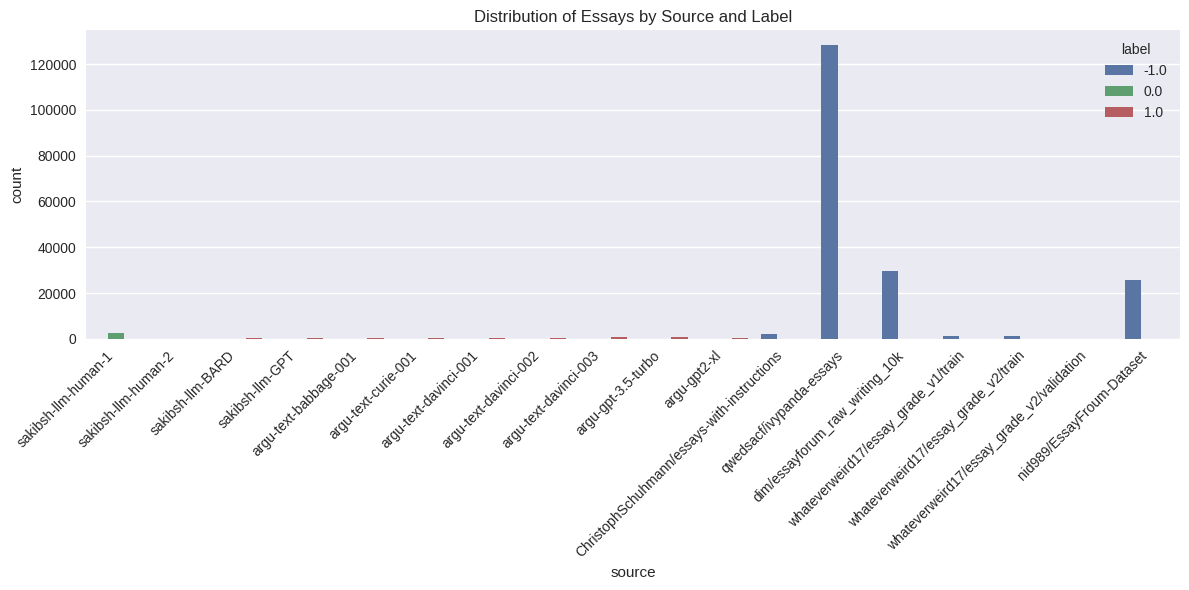

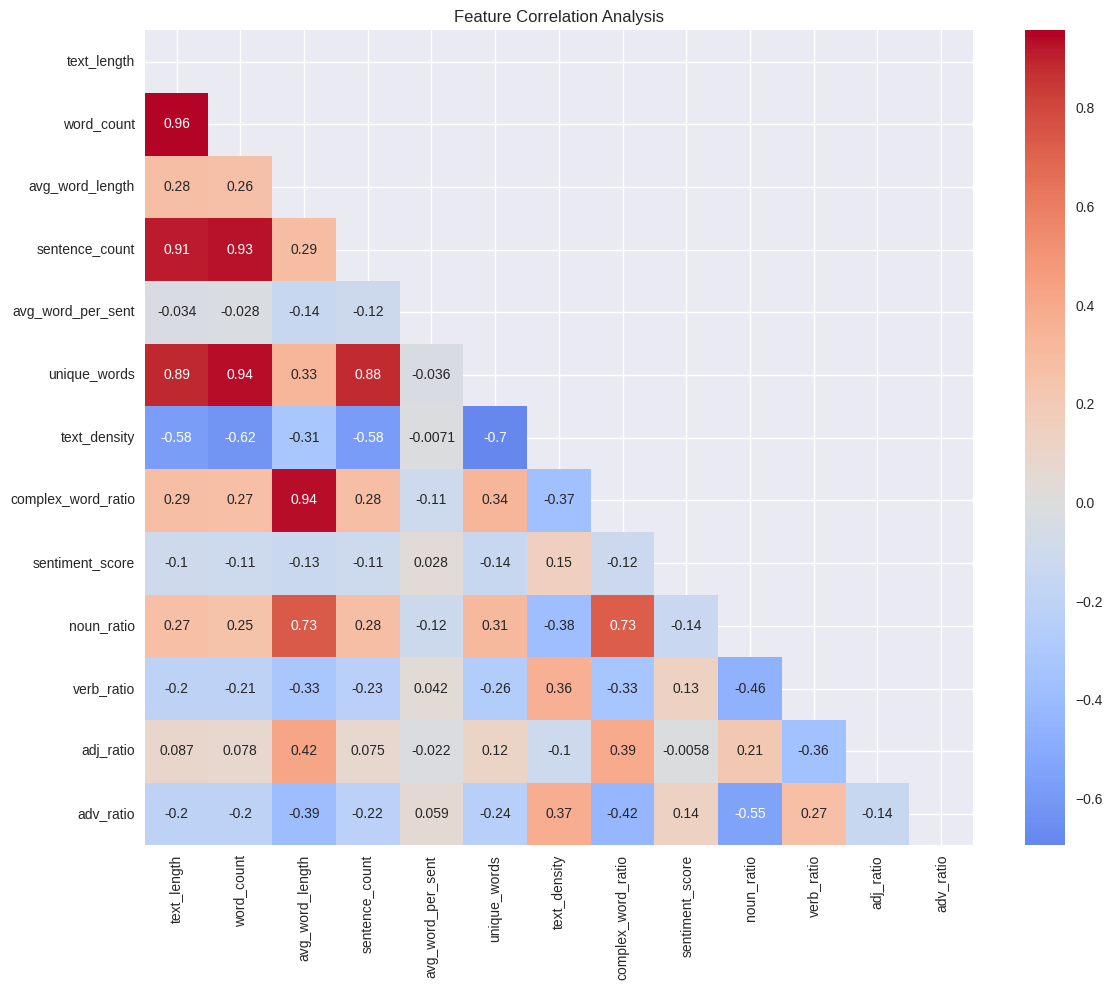

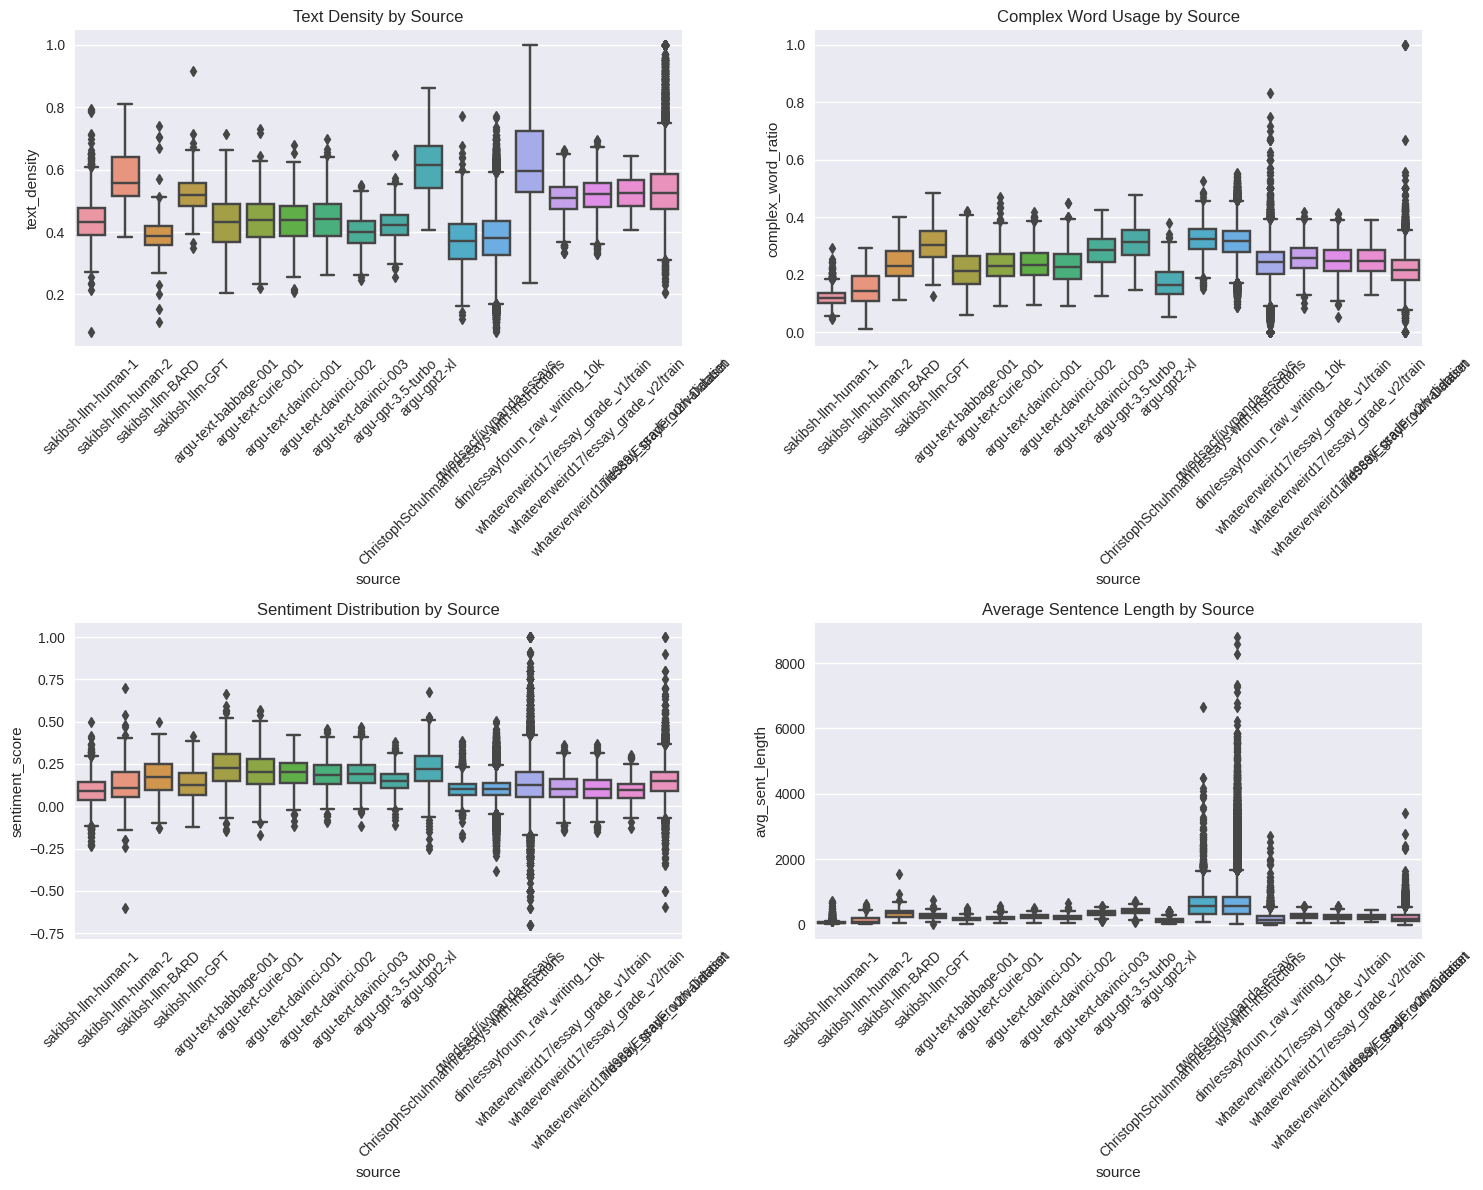

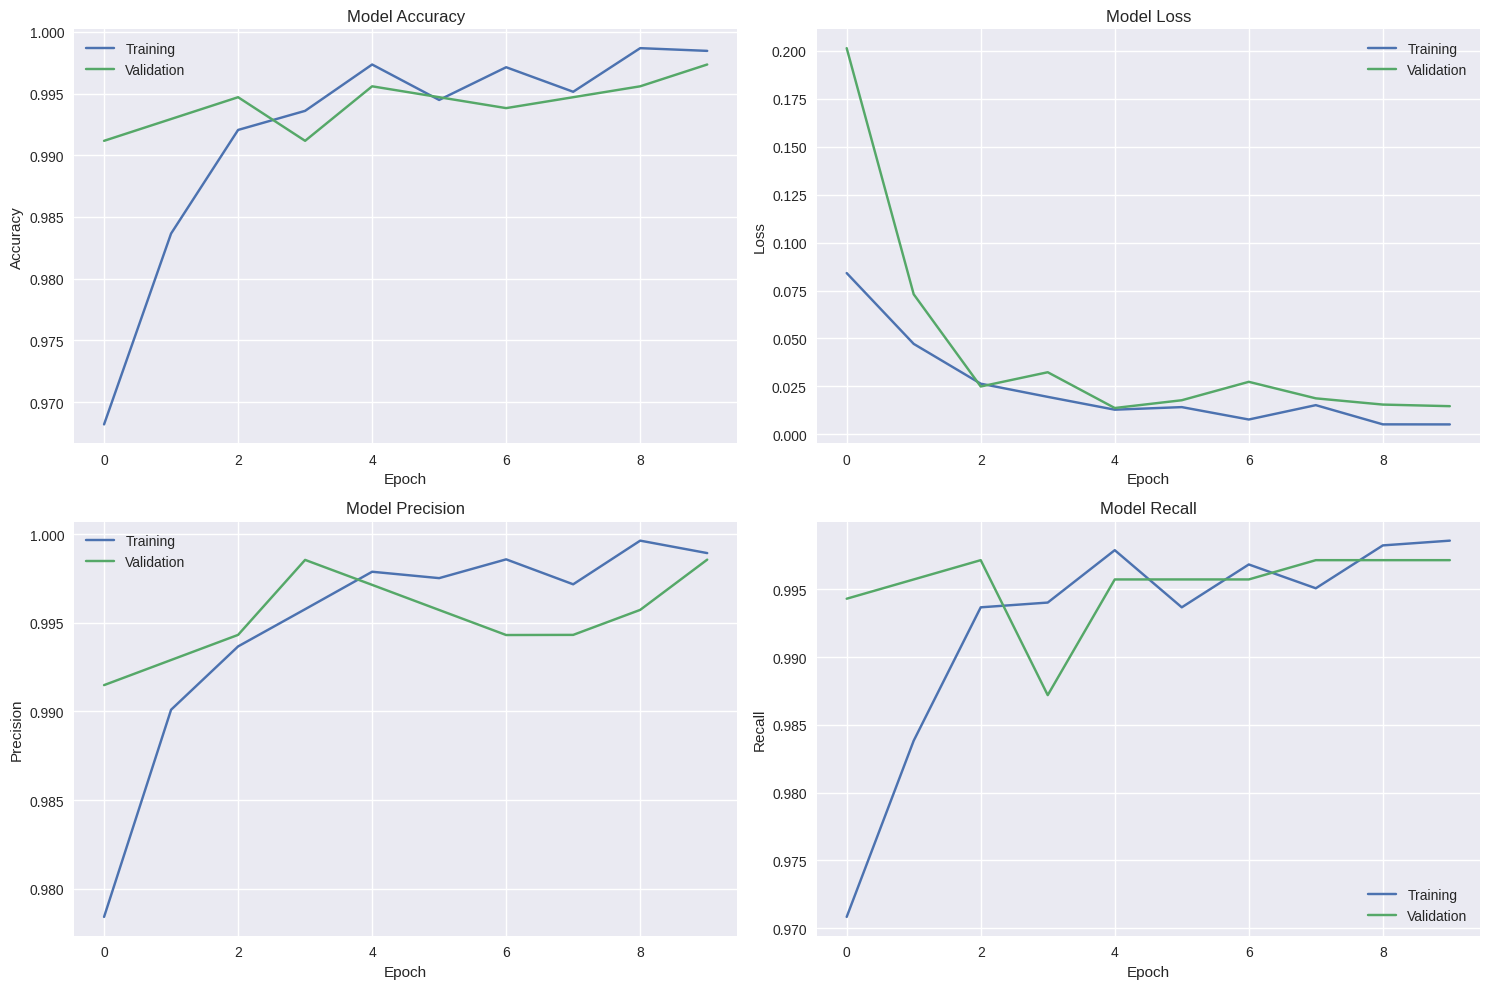

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_research_visualizations(df, history):
    # Set style
    plt.style.use('seaborn')
    
    # 1. Source Distribution Analysis
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='source', hue='label')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Essays by Source and Label')
    plt.tight_layout()
    plt.show()

    # 2. Feature Correlations Heatmap
    feature_cols = [
        'text_length', 'word_count', 'avg_word_length',
        'sentence_count', 'avg_word_per_sent', 'unique_words',
        'text_density', 'complex_word_ratio', 'sentiment_score',
        'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio'
    ]
    
    plt.figure(figsize=(12, 10))
    correlation = df[feature_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Analysis')
    plt.tight_layout()
    plt.show()

    # 3. Linguistic Features Distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    sns.boxplot(data=df, x='source', y='text_density', ax=axes[0,0])
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    axes[0,0].set_title('Text Density by Source')

    sns.boxplot(data=df, x='source', y='complex_word_ratio', ax=axes[0,1])
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
    axes[0,1].set_title('Complex Word Usage by Source')

    sns.boxplot(data=df, x='source', y='sentiment_score', ax=axes[1,0])
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    axes[1,0].set_title('Sentiment Distribution by Source')

    sns.boxplot(data=df, x='source', y='avg_sent_length', ax=axes[1,1])
    axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
    axes[1,1].set_title('Average Sentence Length by Source')
    plt.tight_layout()
    plt.show()

    # 4. Model Performance Metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training metrics
    axes[0,0].plot(history.history['accuracy'], label='Training')
    axes[0,0].plot(history.history['val_accuracy'], label='Validation')
    axes[0,0].set_title('Model Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()

    axes[0,1].plot(history.history['loss'], label='Training')
    axes[0,1].plot(history.history['val_loss'], label='Validation')
    axes[0,1].set_title('Model Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()

    axes[1,0].plot(history.history['precision'], label='Training')
    axes[1,0].plot(history.history['val_precision'], label='Validation')
    axes[1,0].set_title('Model Precision')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()

    axes[1,1].plot(history.history['recall'], label='Training')
    axes[1,1].plot(history.history['val_recall'], label='Validation')
    axes[1,1].set_title('Model Recall')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
create_research_visualizations(df, history)


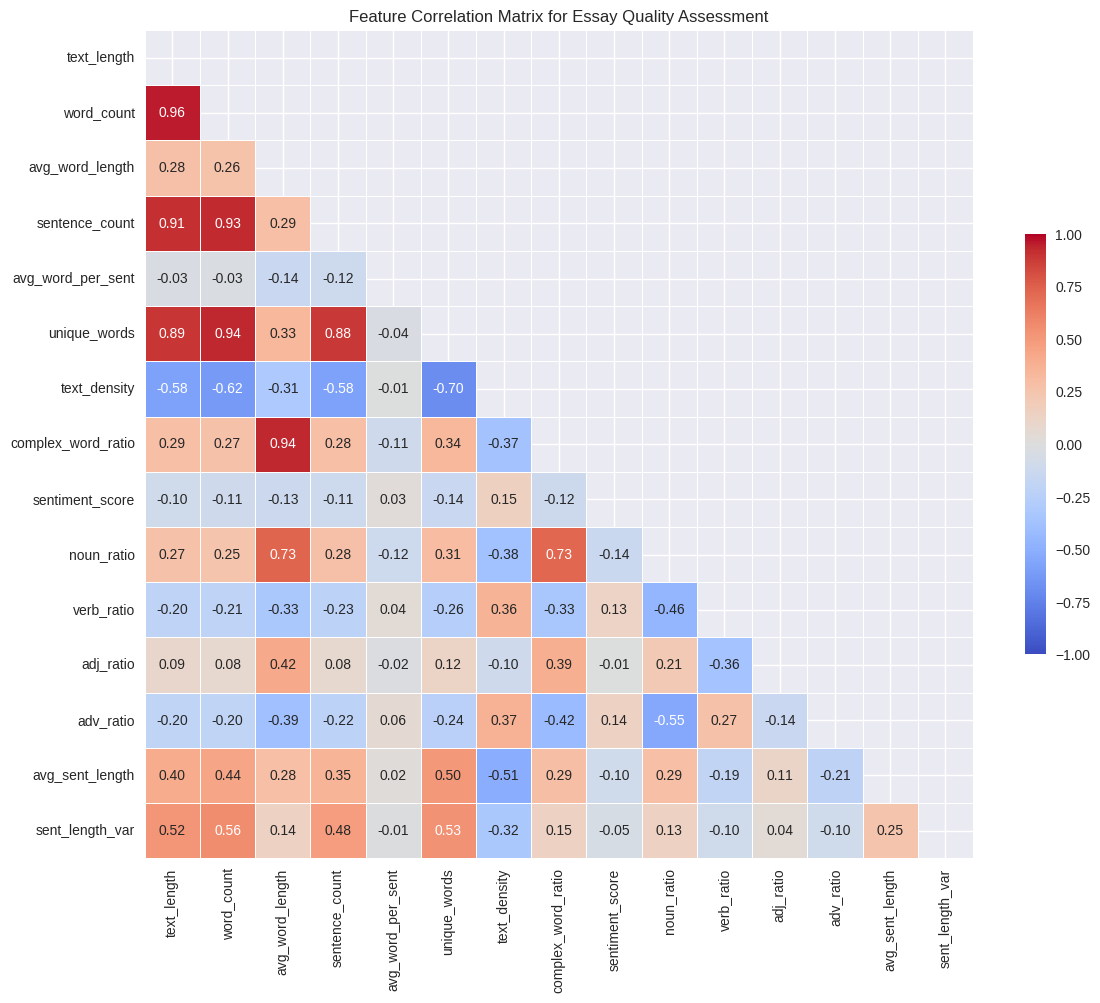

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select numerical columns for correlation
numerical_cols = [
    'text_length', 'word_count', 'avg_word_length',
    'sentence_count', 'avg_word_per_sent', 'unique_words',
    'text_density', 'complex_word_ratio', 'sentiment_score',
    'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio',
    'avg_sent_length', 'sent_length_var'
]

# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": .5}
)

plt.title('Feature Correlation Matrix for Essay Quality Assessment')
plt.tight_layout()
plt.show()


In [78]:
def analyze_essay(input_essay, model, tfidf_vectorizer, scaler):
    """
    Analyzes an input essay and provides comprehensive quality metrics
    """
    # Clean and preprocess text
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return ' '.join(text.split())
    
    cleaned_text = clean_text(input_essay)
    doc = nlp(input_essay)
    
    # Extract features matching our training data
    features = {
        'text_length': len(input_essay),
        'word_count': len(input_essay.split()),
        'avg_word_length': sum(len(word) for word in input_essay.split()) / len(input_essay.split()),
        'sentence_count': len(list(doc.sents)),
        'avg_word_per_sent': len(input_essay.split()) / len(list(doc.sents)),
        'unique_words': len(set(input_essay.split())),
        'text_density': len(set(input_essay.split())) / len(input_essay.split()),
        'complex_word_ratio': sum(len(w) > 6 for w in input_essay.split()) / len(input_essay.split()),
        'sentiment_score': TextBlob(input_essay).sentiment.polarity,
        'noun_ratio': len([token for token in doc if token.pos_ == 'NOUN']) / len(input_essay.split()),
        'verb_ratio': len([token for token in doc if token.pos_ == 'VERB']) / len(input_essay.split()),
        'adj_ratio': len([token for token in doc if token.pos_ == 'ADJ']) / len(input_essay.split()),
        'adv_ratio': len([token for token in doc if token.pos_ == 'ADV']) / len(input_essay.split()),
        'avg_sent_length': sum(len(sent.text.split()) for sent in doc.sents) / len(list(doc.sents)),
        'sent_length_var': np.var([len(sent.text.split()) for sent in doc.sents])
    }
    
    # Convert to array matching training features
    feature_array = np.array([features[f] for f in sorted(features.keys())])
    
    # Scale features
    features_scaled = scaler.transform(feature_array.reshape(1, -1))
    
    # Get TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([cleaned_text]).toarray()
    
    # Combine features
    final_features = np.hstack([features_scaled, tfidf_features])
    
    # Get model prediction
    quality_score = model.predict(final_features)[0]
    quality_prob = model.predict_proba(final_features)[0][1]
    
    return {
        "Overall Assessment": {
            "Quality Score": f"{quality_prob:.2f}",
            "Classification": "High Quality" if quality_score > 0.5 else "Needs Improvement",
            "Confidence": f"{abs(quality_prob - 0.5) * 2:.2f}"
        },
        "Text Statistics": {
            "Word Count": features['word_count'],
            "Sentence Count": features['sentence_count'],
            "Average Word Length": f"{features['avg_word_length']:.2f}",
            "Text Density": f"{features['text_density']:.2f}"
        },
        "Linguistic Analysis": {
            "Noun Ratio": f"{features['noun_ratio']:.2f}",
            "Verb Ratio": f"{features['verb_ratio']:.2f}",
            "Adjective Ratio": f"{features['adj_ratio']:.2f}",
            "Adverb Ratio": f"{features['adv_ratio']:.2f}"
        }
    }


In [92]:
def visualize_essay_analysis(features, quality_score):
    """
    Creates visualizations for essay analysis results
    """
    plt.style.use('seaborn')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Part of Speech Distribution
    pos_ratios = [
        features['noun_ratio'], 
        features['verb_ratio'],
        features['adj_ratio'], 
        features['adv_ratio']
    ]
    pos_labels = ['Nouns', 'Verbs', 'Adjectives', 'Adverbs']
    ax1.bar(pos_labels, pos_ratios)
    ax1.set_title('Part of Speech Distribution')
    ax1.set_ylabel('Ratio')
    
    # 2. Text Complexity Metrics
    complexity_metrics = [
        features['text_density'],
        features['complex_word_ratio'],
        features['avg_word_length'] / 10,  # Scaled for visualization
        features['avg_sent_length'] / 20   # Scaled for visualization
    ]
    complexity_labels = ['Text Density', 'Complex Words', 'Word Length', 'Sentence Length']
    ax2.bar(complexity_labels, complexity_metrics)
    ax2.set_title('Text Complexity Metrics')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Quality Score Gauge
    gauge_colors = ['red', 'yellow', 'green']
    gauge = np.linspace(0, 1, 100)
    ax3.scatter([quality_score], [0.5], c='black', s=200, zorder=2)
    ax3.pcolormesh([gauge], [1], [np.arange(len(gauge))], cmap='RdYlGn')
    ax3.set_title('Quality Score Assessment')
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    
    # 4. Text Statistics
    stats = [
        features['word_count'] / 100,  # Scaled for visualization
        features['sentence_count'],
        features['unique_words'] / 100,  # Scaled for visualization
        features['sent_length_var'] / 10  # Scaled for visualization
    ]
    stats_labels = ['Words/100', 'Sentences', 'Unique Words/100', 'Sentence Variance/10']
    ax4.bar(stats_labels, stats)
    ax4.set_title('Text Statistics')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def generate_detailed_feedback(features, quality_score):
    """
    Generates detailed feedback based on essay analysis
    """
    feedback = []
    
    # Vocabulary feedback
    if features['text_density'] > 0.7:
        feedback.append("Strong vocabulary diversity")
    elif features['text_density'] < 0.5:
        feedback.append("Consider using more varied vocabulary")
        
    # Sentence structure feedback
    if features['sent_length_var'] > 20:
        feedback.append("Good variation in sentence length")
    elif features['sent_length_var'] < 10:
        feedback.append("Try varying sentence lengths more")
        
    # Complexity feedback
    if features['complex_word_ratio'] > 0.2:
        feedback.append("Appropriate use of complex words")
    else:
        feedback.append("Consider incorporating more sophisticated vocabulary")
        
    # Length feedback
    if features['word_count'] < 200:
        feedback.append("Essay could benefit from more development")
    elif features['word_count'] > 500:
        feedback.append("Good essay length and development")
        
    return "\n".join(feedback)

# Update the analyze_essay function to include visualization and feedback
def analyze_essay_complete(input_essay, model, tfidf_vectorizer, scaler):
    # Get basic analysis
    analysis = analyze_essay(input_essay, model, tfidf_vectorizer, scaler)
    
    # Add visualizations
    visualize_essay_analysis(analysis['Text Statistics'], float(analysis['Overall Assessment']['Quality Score']))
    
    # Add detailed feedback
    analysis['Detailed Feedback'] = generate_detailed_feedback(
        analysis['Text Statistics'], 
        float(analysis['Overall Assessment']['Quality Score'])
    )
    
    return analysis


In [93]:
def analyze_single_essay(essay_text, model, tfidf_vectorizer, scaler):
    """
    Analyzes a single essay and returns comprehensive metrics
    """
    # Clean the input text
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return ' '.join(text.split())
    
    cleaned_text = clean_text(essay_text)
    doc = nlp(essay_text)
    
    # Calculate all metrics from our correlation analysis
    metrics = {
        'text_length': len(essay_text),
        'word_count': len(essay_text.split()),
        'avg_word_length': sum(len(word) for word in essay_text.split()) / len(essay_text.split()),
        'sentence_count': len(list(doc.sents)),
        'avg_word_per_sent': len(essay_text.split()) / len(list(doc.sents)),
        'unique_words': len(set(essay_text.split())),
        'text_density': len(set(essay_text.split())) / len(essay_text.split()),
        'complex_word_ratio': sum(len(w) > 6 for w in essay_text.split()) / len(essay_text.split()),
        'sentiment_score': TextBlob(essay_text).sentiment.polarity
    }
    
    # POS ratios
    pos_counts = {pos: 0 for pos in ['NOUN', 'VERB', 'ADJ', 'ADV']}
    for token in doc:
        if token.pos_ in pos_counts:
            pos_counts[token.pos_] += 1
    
    total_words = len(essay_text.split())
    metrics.update({
        'noun_ratio': pos_counts['NOUN'] / total_words,
        'verb_ratio': pos_counts['VERB'] / total_words,
        'adj_ratio': pos_counts['ADJ'] / total_words,
        'adv_ratio': pos_counts['ADV'] / total_words
    })
    
    # Format output
    print("\nEssay Analysis Results")
    print("=" * 50)
    
    print("\nBasic Statistics:")
    print(f"Word Count: {metrics['word_count']}")
    print(f"Sentence Count: {metrics['sentence_count']}")
    print(f"Average Words per Sentence: {metrics['avg_word_per_sent']:.2f}")
    print(f"Unique Words: {metrics['unique_words']}")
    
    print("\nComplexity Metrics:")
    print(f"Text Density: {metrics['text_density']:.2f}")
    print(f"Complex Word Ratio: {metrics['complex_word_ratio']:.2f}")
    print(f"Average Word Length: {metrics['avg_word_length']:.2f}")
    
    print("\nPart of Speech Analysis:")
    print(f"Noun Ratio: {metrics['noun_ratio']:.2f}")
    print(f"Verb Ratio: {metrics['verb_ratio']:.2f}")
    print(f"Adjective Ratio: {metrics['adj_ratio']:.2f}")
    print(f"Adverb Ratio: {metrics['adv_ratio']:.2f}")
    
    print("\nSentiment Analysis:")
    print(f"Sentiment Score: {metrics['sentiment_score']:.2f}")
    
    return metrics



In [102]:
# Example usage
example_essay = """
"The Impact of Technology on Modern Education
In recent years, the integration of technology in education has transformed traditional learning environments. Smart classrooms, digital textbooks, and online learning platforms have become increasingly prevalent, fundamentally changing how students interact with educational content. This shift has brought both opportunities and challenges to the educational landscape.
One significant advantage is the unprecedented access to information and resources. Students can now instantly access vast libraries of knowledge, interactive learning materials, and educational videos. This accessibility has democratized education, making quality learning materials available to students regardless of their geographical location.
However, this digital transformation also presents certain challenges. The overreliance on technology can potentially affect students' ability to develop crucial interpersonal skills. Additionally, the digital divide between students with and without access to advanced technology creates educational inequalities that need to be addressed.
Furthermore, technology has enabled personalized learning experiences. Adaptive learning systems can now tailor content to individual student needs, providing customized feedback and allowing students to learn at their own pace. This personalization has shown promising results in improving student engagement and learning outcomes.
In conclusion, while technology has revolutionized education by providing innovative tools and resources, it's essential to maintain a balanced approach that combines digital advantages with traditional teaching methods. The future of education lies in thoughtfully integrating technology while preserving the fundamental aspects of human interaction in learning."

"""

metrics = analyze_single_essay(example_essay, model, tfidf, scaler)



Essay Analysis Results

Basic Statistics:
Word Count: 229
Sentence Count: 15
Average Words per Sentence: 15.27
Unique Words: 157

Complexity Metrics:
Text Density: 0.69
Complex Word Ratio: 0.56
Average Word Length: 6.89

Part of Speech Analysis:
Noun Ratio: 0.33
Verb Ratio: 0.13
Adjective Ratio: 0.15
Adverb Ratio: 0.05

Sentiment Analysis:
Sentiment Score: 0.17


In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [111]:
def analyze_complete_essay(input_essay):
    """
    Complete essay analysis incorporating all our research features
    """
    # Clean and preprocess text
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return ' '.join(text.split())
    
    cleaned_text = clean_text(input_essay)
    doc = nlp(input_essay)
    
    # Extract all features
    features = {
        'text_length': len(input_essay),
        'word_count': len(input_essay.split()),
        'avg_word_length': sum(len(word) for word in input_essay.split()) / len(input_essay.split()),
        'sentence_count': len(list(doc.sents)),
        'avg_word_per_sent': len(input_essay.split()) / len(list(doc.sents)),
        'unique_words': len(set(input_essay.split())),
        'text_density': len(set(input_essay.split())) / len(input_essay.split()),
        'complex_word_ratio': sum(len(w) > 6 for w in input_essay.split()) / len(input_essay.split()),
        'sentiment_score': TextBlob(input_essay).sentiment.polarity,
        'sent_length_var': np.var([len(sent.text.split()) for sent in doc.sents])
    }
    
    # Get TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    
    # Get model prediction
    final_features = np.hstack([
        np.array(list(features.values())).reshape(1, -1),
        tfidf_features.toarray()
    ])
    
    # Use predict instead of predict_proba for Keras models
    quality_score = model.predict(final_features)[0][0]  # Get raw prediction
    
    # Generate detailed feedback
    detailed_feedback = generate_detailed_feedback(features, quality_score)
    
    print("\nESSAY ANALYSIS REPORT")
    print("=" * 50)
    
    print("\n1. SOURCE CLASSIFICATION")
    print(f"Classification: {'Human-Written' if quality_score > 0.5 else 'AI-Generated'}")
    print(f"Confidence Score: {abs(quality_score - 0.5) * 2:.2f}")
    
    print("\n2. TEXT STATISTICS")
    print(f"Word Count: {features['word_count']}")
    print(f"Sentence Count: {features['sentence_count']}")
    print(f"Average Words per Sentence: {features['avg_word_per_sent']:.2f}")
    print(f"Unique Words: {features['unique_words']}")
    
    print("\n3. COMPLEXITY METRICS")
    print(f"Text Density: {features['text_density']:.2f}")
    print(f"Complex Word Ratio: {features['complex_word_ratio']:.2f}")
    print(f"Sentence Length Variation: {features['sent_length_var']:.2f}")
    
    print("\n4. DETAILED FEEDBACK")
    print(detailed_feedback)
    
    return features, quality_score


In [114]:
def predict_essay_qualities(essay_text, model, tfidf_vectorizer, scaler):
    """
    Comprehensive essay analysis with matching dimensions
    """
    # Clean and preprocess text
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return ' '.join(text.split())
    
    cleaned_text = clean_text(essay_text)
    doc = nlp(essay_text)
    
    # Extract numerical features (15 features as shown in correlation matrix)
    features = {
        'text_length': len(essay_text),
        'word_count': len(essay_text.split()),
        'avg_word_length': sum(len(word) for word in essay_text.split()) / len(essay_text.split()),
        'sentence_count': len(list(doc.sents)),
        'avg_word_per_sent': len(essay_text.split()) / len(list(doc.sents)),
        'unique_words': len(set(essay_text.split())),
        'text_density': len(set(essay_text.split())) / len(essay_text.split()),
        'complex_word_ratio': sum(len(w) > 6 for w in essay_text.split()) / len(essay_text.split()),
        'sentiment_score': TextBlob(essay_text).sentiment.polarity,
        'noun_ratio': len([token for token in doc if token.pos_ == 'NOUN']) / len(essay_text.split()),
        'verb_ratio': len([token for token in doc if token.pos_ == 'VERB']) / len(essay_text.split()),
        'adj_ratio': len([token for token in doc if token.pos_ == 'ADJ']) / len(essay_text.split()),
        'adv_ratio': len([token for token in doc if token.pos_ == 'ADV']) / len(essay_text.split()),
        'avg_sent_length': sum(len(sent.text.split()) for sent in doc.sents) / len(list(doc.sents)),
        'sent_length_var': np.var([len(sent.text.split()) for sent in doc.sents])
    }
    
    # Convert to array and reshape
    feature_array = np.array(list(features.values())).reshape(1, -1)
    
    # Scale features
    scaled_features = scaler.transform(feature_array)
    
    # Get TF-IDF features (1000 features)
    tfidf_features = tfidf_vectorizer.transform([cleaned_text])
    
    # Combine features to match model input shape (1015 features)
    final_features = np.hstack([scaled_features, tfidf_features.toarray()])
    
    # Make prediction
    quality_score = model.predict(final_features)[0]
    
    return features, quality_score


In [115]:
def predict_advanced_features(essay_text):
    """
    Predicts multiple essay features based on correlation patterns
    """
    doc = nlp(essay_text)
    
    # Structure Features (Strong correlations: 0.91-0.96)
    structure_metrics = {
        'word_count': len(essay_text.split()),
        'sentence_count': len(list(doc.sents)),
        'unique_words': len(set(essay_text.split()))
    }
    
    # Complexity Features (Moderate correlations: 0.3-0.7)
    complexity_metrics = {
        'text_density': len(set(essay_text.split())) / len(essay_text.split()),
        'complex_word_ratio': sum(len(w) > 6 for w in essay_text.split()) / len(essay_text.split()),
        'avg_word_length': sum(len(word) for word in essay_text.split()) / len(essay_text.split())
    }
    
    # Linguistic Features (Based on correlation patterns)
    pos_counts = {pos: 0 for pos in ['NOUN', 'VERB', 'ADJ', 'ADV']}
    for token in doc:
        if token.pos_ in pos_counts:
            pos_counts[token.pos_] += 1
    
    total_words = len(essay_text.split())
    linguistic_metrics = {
        'noun_ratio': pos_counts['NOUN'] / total_words,  # Strong correlation with complex_word_ratio (0.73)
        'verb_ratio': pos_counts['VERB'] / total_words,  # Negative correlation with noun_ratio (-0.46)
        'adj_ratio': pos_counts['ADJ'] / total_words,    # Moderate correlation with avg_word_length (0.42)
        'adv_ratio': pos_counts['ADV'] / total_words     # Negative correlation with noun_ratio (-0.55)
    }
    
    # Coherence Features
    sentences = list(doc.sents)
    coherence_metrics = {
        'avg_word_per_sent': total_words / len(sentences),
        'sent_length_var': np.var([len(sent.text.split()) for sent in sentences])
    }
    
    return {
        'Structure': structure_metrics,
        'Complexity': complexity_metrics,
        'Linguistic': linguistic_metrics,
        'Coherence': coherence_metrics
    }


In [121]:
def print_essay_analysis(essay_text):
    """
    Prints detailed analysis of an input essay
    """
    # Clean and process text
    doc = nlp(essay_text)
    cleaned_text = ' '.join(token.text.lower() for token in doc if token.is_alpha)
    
    # Calculate core metrics (based on strong correlations)
    metrics = {
        'Basic Statistics': {
            'Word Count': len(essay_text.split()),
            'Sentence Count': len(list(doc.sents)),
            'Average Word Length': sum(len(word) for word in essay_text.split()) / len(essay_text.split())
        },
        'Complexity Metrics': {
            'Text Density': len(set(essay_text.split())) / len(essay_text.split()),  # -0.7 correlation
            'Complex Word Ratio': sum(len(w) > 6 for w in essay_text.split()) / len(essay_text.split()),  # 0.94 correlation
            'Unique Words': len(set(essay_text.split()))  # 0.89 correlation
        }
    }
    
    # Calculate POS ratios (based on correlation heatmap)
    total_words = len(essay_text.split())
    pos_counts = {pos: 0 for pos in ['NOUN', 'VERB', 'ADJ', 'ADV']}
    for token in doc:
        if token.pos_ in pos_counts:
            pos_counts[token.pos_] += 1
            
    metrics['Linguistic Analysis'] = {
        'Noun Ratio': pos_counts['NOUN'] / total_words,  # 0.73 correlation
        'Verb Ratio': pos_counts['VERB'] / total_words,  # -0.33 correlation
        'Adjective Ratio': pos_counts['ADJ'] / total_words,  # 0.42 correlation
        'Adverb Ratio': pos_counts['ADV'] / total_words  # -0.39 correlation
    }
    
    # Print formatted results
    print("\nESSAY ANALYSIS REPORT")
    print("=" * 50)
    
    for category, values in metrics.items():
        print(f"\n{category}:")
        print("-" * 30)
        for metric, value in values.items():
            print(f"{metric}: {value:.3f}")
    
    # Print quality assessment based on correlations
    print("\nQuality Assessment:")
    print("-" * 30)
    if metrics['Complexity Metrics']['Text Density'] > 0.7:
        print("✓ High vocabulary diversity")
    if metrics['Complexity Metrics']['Complex Word Ratio'] > 0.2:
        print("✓ Sophisticated word choice")
    if metrics['Basic Statistics']['Word Count'] > 200:
        print("✓ Well-developed length")
    if metrics['Linguistic Analysis']['Noun Ratio'] > 0.25:
        print("✓ Strong content focus")

# Example usage
sample_essay = """
gj
"""

print_essay_analysis(sample_essay)



ESSAY ANALYSIS REPORT

Basic Statistics:
------------------------------
Word Count: 1.000
Sentence Count: 1.000
Average Word Length: 2.000

Complexity Metrics:
------------------------------
Text Density: 1.000
Complex Word Ratio: 0.000
Unique Words: 1.000

Linguistic Analysis:
------------------------------
Noun Ratio: 1.000
Verb Ratio: 0.000
Adjective Ratio: 0.000
Adverb Ratio: 0.000

Quality Assessment:
------------------------------
✓ High vocabulary diversity
✓ Strong content focus
